<img src="./images/DLI_Header.png" style="width: 400px;">

# 資料增強

目前為止，我們選擇的模型架構大幅提升了模型的效能，因為這是專為識別影像中的重要特徵而設計的架構。驗證準確度仍然不及訓練準確度，這就是過度擬合的跡象：在以驗證資料集進行測試時，模型會因為先前未見過的影像而混淆。

為了讓模型在檢視新資料時有更可靠的表現，我們要透過程式設計的方式增加資料集的大小和變異數。這就是所謂的[*資料增強*](https://link.springer.com/article/10.1186/s40537-019-0197-0)，對於眾多深度學習應用程式而言都是很有用的技術。

資料規模增加後可讓模型在訓練時從更多影像中學習。變異數增加則有助於模型忽略不重要的特徵，並且只選出對分類有用的特徵，讓模型具備更出色的歸納能力。

## 目標

* 增強 ASL 資料集
* 使用已增強的資料訓練經過改善的模型
* 將完成訓練的模型儲存到磁碟以用於部署

## 準備資料

現在我們使用的是新的 Notebook，所以要再次載入和處理資料。請執行下列儲存格以完成操作：

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_df = pd.read_csv("asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## 模型建立

我們也需要再次建立模型。請執行下列儲存格以完成操作。你應該有注意到，這個模型架構和上一節相同：

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## 資料增強

在編譯模型之前，首先要設定資料增強。

Keras 中的影像增強類別 `ImageDataGenerator`。建議你查看[這裡的說明文件](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)。這個類別可接受各種用於增強資料的選項。在本課程後半段，我們會請你選擇適用的增強策略。現在，請看看我們在下方選取的選項，然後執行儲存格以建立類別的執行個體：

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

請花點時間思考一下，為什麼我們要水平翻轉影像，而不是垂直翻轉。有想法之後，請展開下方文字。

我們的資料集是由用手勢表示字母的圖片組成。如果我們想要在之後使用此模型來分類手勢影像，這些手勢不太可能會是上下顛倒的狀態，但卻有可能是左手的手勢。這種領域專屬的推理有助於為你的深度學習應用程式做出理想決策。

## 批次大小
`ImageDataGenerator`的另一個優點是可以[批次處理](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)我們的資料，讓模型能以隨機的樣本進行訓練。

如果模型是[真正的隨機](http://sites.utexas.edu/sos/random/)，表示資料確實經過隨機排列，就像洗好的牌一樣公平，因此我們的樣本可以完整代表所有的資料，即使這只是整體的一小部分。在訓練的每個步驟中，模型都會處理到新的批次。

在實務上，批次大小為 32 和 64 的效果比較理想。執行下方儲存格，看看我們是以哪種類型的批次訓練模型。我們的隨機生成器有做到公平地隨機排列嗎？所有的影像都是可辨識的美國手語字母嗎？

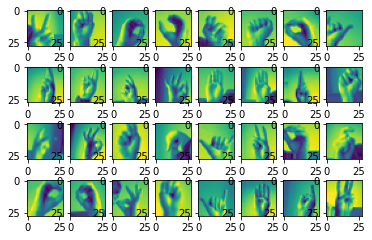

In [4]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## 將資料擬合生成器

接下來，生成器必須在訓練資料集上擬合。

In [5]:
datagen.fit(x_train)

## 編譯模型

資料生成器執行個體已建立並擬合訓練資料之後，現在模型可以按照先前範例中的方式進行編譯：

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## 透過增強進行訓練

透過 Keras 使用影像資料生成器時，模型的訓練方式會有所不同：不只是傳遞 `x_train`和 `y_train` 資料集到模型，而是會傳遞生成器，並呼叫生成器的 [flow](https://keras.io/api/preprocessing/image/) 方法。因此影像在傳遞至模型進行訓練前，會在記憶體中即時增強。

生成器可以提供數量不定的資料，當我們使用這些資料來訓練時，需要明確設定每個 Epoch 的執行時間，否則 Epoch 會無限期持續執行，而生成器則會建立無限多數量的增強影像來提供給模型。

我們會使用 `steps_per_epoch`具名引數來明確設定每個 Epoch 的執行時間。由於我們會在這裡使用 `steps * batch_size = number_of_images_trained in an epoch`的常見做法，也就是將步驟數設定為等於未增強資料集大小除以 batch_size (其預設值為 32)。

執行下列儲存格以查看結果。訓練時間比先前更長，畢竟我們現在比之前使用更多資料進行訓練。

In [7]:
model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/20
858/857 [==============================] - 10s 12ms/step - loss: 1.0865 - accuracy: 0.6541 - val_loss: 0.4764 - val_accuracy: 0.8410
Epoch 2/20
858/857 [==============================] - 9s 11ms/step - loss: 0.3201 - accuracy: 0.8920 - val_loss: 0.1488 - val_accuracy: 0.9508
Epoch 3/20
858/857 [==============================] - 9s 11ms/step - loss: 0.2017 - accuracy: 0.9331 - val_loss: 0.3158 - val_accuracy: 0.9110
Epoch 4/20
858/857 [==============================] - 9s 11ms/step - loss: 0.1516 - accuracy: 0.9505 - val_loss: 0.4476 - val_accuracy: 0.8871
Epoch 5/20
858/857 [==============================] - 9s 11ms/step - loss: 0.1207 - accuracy: 0.9612 - val_loss: 0.5210 - val_accuracy: 0.8574
Epoch 6/20
858/857 [==============================] - 10s 11ms/step - loss: 0.1092 - accuracy: 0.9644 - val_loss: 0.6252 - val_accuracy: 0.8592
Epoch 7/20
858/857 [==============================] - 9s 10ms/step - loss: 0.0932 - accuracy: 0.9699 - val_loss: 0.0539 - val_accuracy: 0.98

## 結果討論

你會發現驗證準確度提高了，也比較一致。這表示我們的模型已不再像之前過度擬合，而是具備更好的歸納能力，對於新資料的預測也更準確。

## 儲存模型

現在我們的模型已經過完整訓練，我們希望部署模型來對新影像執行推論。

常見的做法是，將模型訓練到理想狀態之後，就儲存到磁碟。

使用 save 方法就能輕鬆將模型儲存在 Keras。我們可以選用不同的格式儲存，但這次先使用預設格式。如有需要，歡迎查看[說明文件](https://www.tensorflow.org/guide/keras/save_and_serialize)。在下個 Notebook 中，我們會載入模型並用於讀取新的手語圖片：

In [8]:
model.save('asl_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: asl_model/assets


## 摘要

在本節中，你使用了 Keras 來增強資料集，結果是經過訓練的模型比較沒有過度擬合的現象，在驗證影像上的表現則很理想。

### 清除記憶體
在繼續之前，請執行下列儲存格以清除 GPU 記憶體。

In [9]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## 下一步

現在你已將經過完整訓練的模型儲存在磁碟，在下一節，你將會部署模型並用於預測尚未看過的影像。

請繼續前往下一節：[*模型預測*](04b_asl_predictions.ipynb)。